In [1]:
import tensorflow as tf
import time

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)

In [2]:
import tarfile
import re
import urllib.request
import os
import random

class ImdbMovieReviews:
    DEFAULT_URL = \
        'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
    TOKEN_REGEX = re.compile(r'[A-Za-z]+|[!?.:,()]')
    
    def __init__(self):
        self._cache_dir = './imdb'
        self._url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
        
        if not os.path.isfile(self._cache_dir):
            urllib.request.urlretrieve(self._url, self._cache_dir)
        self.filepath = self._cache_dir

    def __iter__(self):
        with tarfile.open(self.filepath) as archive:
            items = archive.getnames()
            for filename in archive.getnames():
                if filename.startswith('aclImdb/train/pos/'):
                    yield self._read(archive, filename), True
                elif filename.startswith('aclImdb/train/neg/'):
                    yield self._read(archive, filename), False
                    
    def _read(self, archive, filename):
        with archive.extractfile(filename) as file_:
            data = file_.read().decode('utf-8')
            data = type(self).TOKEN_REGEX.findall(data)
            data = [x.lower() for x in data]
            return data

In [3]:
import numpy as np
# Spacy is my favourite nlp framework, which havu builtin word embeddings trains on wikipesia
from spacy.en import English

class Embedding:
    
    def __init__(self):
#          spaCy makes using word vectors very easy. 
#             The Lexeme , Token , Span  and Doc  classes all have a .vector property,
#             which is a 1-dimensional numpy array of 32-bit floats:
        self.parser = English()
#         self._length = length
        self.dimensions = 300
        
    def __call__(self, sequence, length):
        # DO I really need them to be equal length?
        # Let's assume I'm not
        data = np.zeros((length, self.dimensions))
        # you can access known words from the parser's vocabulary
        embedded = [self.parser.vocab[w].vector for w in sequence]
        data[:len(sequence)] = embedded
        return data

In [4]:
import itertools

def preprocess_batched_split(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch = []
        labelss = []
        sentence_sizes_batch = []
        for index in range(batch_size):
            text, label = next(iterator)
            sents = [list(y) for x, y in itertools.groupby(text, lambda z: z == '.') if not x]
            sentence_sizes = [len(s) for s in sents]
            text_embed = [embedding(sent) for sent in sents]
            
            batch.append(text_embed)
            labelss.append(label)
            sentence_sizes_batch.append(sentence_sizes)
            
        labels_batch = np.array(labelss, dtype=np.int32)
        sent_per_doc = np.array([len(x) for x in sentence_sizes_batch])
        words_per_sent_per_doc = np.array(sentence_sizes_batch)
        yield np.array(batch), labels_batch, words_per_sent_per_doc, sent_per_doc

In [5]:
import itertools

def preprocess_batched_split2(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch, labels_b = zip(*itertools.islice(iterator, batch_size))
        
        sents_b = [[list(y) for x, y in itertools.groupby(doc, lambda z: z == '.') if not x] for doc in batch]

        sentence_sizes_b = [[len(sent) for sent in doc] for doc in sents_b]
        sentence_size = max(map(max, sentence_sizes_b))
        
        document_sizes = np.array([len(doc) for doc in sentence_sizes_b], dtype=np.int32)
        document_size = document_sizes.max()

        sentence_sizes_np = np.zeros(shape=[batch_size, document_size], dtype=np.int32)
        for bi, ds, ss in zip(range(sentence_sizes_np.shape[0]), document_sizes, sentence_sizes_b):
            sentence_sizes_np[bi][:ds] = ss
        
        text_embed_b = np.zeros((batch_size, document_size, sentence_size, 300))
        for i, ds, doc_sents in zip(range(text_embed_b.shape[0]), document_sizes, sents_b):
            doc_sents_embed = np.array([embedding(sent, sentence_size) for sent in doc_sents])
            text_embed_b[i][:ds] = doc_sents_embed
        
        yield text_embed_b, np.array(labels_b, dtype=np.int32), np.array(document_sizes), sentence_sizes_np, sents_b

In [6]:
import itertools
#reviews = list(itertools.islice(ImdbMovieReviews(), 200))
reviews = list(ImdbMovieReviews())

In [7]:
random.shuffle(reviews)

In [8]:
batches_split = preprocess_batched_split2(reviews, Embedding(), batch_size=10)

In [9]:
from HanSequenceLabellingModel import HanSequenceLabellingModel

In [10]:
def HAN_model_1(session, restore_only=False):
    """Hierarhical Attention Network"""
    import tensorflow as tf
    try:
        from tensorflow.contrib.rnn import GRUCell, MultiRNNCell, DropoutWrapper
    except ImportError:
        MultiRNNCell = tf.nn.rnn_cell.MultiRNNCell
        GRUCell = tf.nn.rnn_cell.GRUCell
    from bn_lstm import BNLSTMCell
    from HanSequenceLabellingModel import HanSequenceLabellingModel

    is_training = tf.placeholder(dtype=tf.bool, name='is_training')

    cell = BNLSTMCell(80, is_training) # h-h batchnorm LSTMCell
    cell = MultiRNNCell([cell]*5)

    model = HanSequenceLabellingModel(
            embedding_size=300,
            classes=2,
            word_cell=cell,
            sentence_cell=cell,
            word_output_size=300,
            sentence_output_size=300,
            learning_rate=0.001,
            max_grad_norm=5.0,
            dropout_keep_proba=0.5,
            is_training=is_training,
    )

    saver = tf.train.Saver(tf.global_variables())
    checkpoint_dir = 'checkpoints'
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    if checkpoint:
        print("Reading model parameters from %s" % checkpoint.model_checkpoint_path)
        saver.restore(session, checkpoint.model_checkpoint_path)
    elif restore_only:
        raise FileNotFoundError("Cannot restore model")
    else:
        print("Created model with fresh parameters")
        session.run(tf.global_variables_initializer())
        
    return model, saver

In [11]:
# https://stackoverflow.com/questions/25698448/how-to-embed-html-into-ipython-output
# https://www.w3schools.com/css/css_image_transparency.asp
from IPython.core.display import display, HTML
display(HTML('<h1 style="background: rgba(76, 175, 80, 0.1)">Hello, world!</h1>'))

In [ ]:
tf.reset_default_graph()

config = tf.ConfigProto(
#    device_count = {'GPU': 0}, 
    gpu_options=gpu_options
)

weights_to_plot = {
    False: {'good': [], 'bad': []},
    True: {'good': [], 'bad': []}
}


with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s, True)
    tflog_dir = 'tf_logs'
    summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())
    
    # (num_revs * max_num_sentences) x max_num_words_in_sentence
    word_weights = tf.get_default_graph().get_tensor_by_name("word_level/word/attention/attention/Softmax:0")
    # num_reviews x max_num_sentences
    sentence_weights = tf.get_default_graph().get_tensor_by_name("sentence_level/sentence/attention/attention/Softmax:0")

    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sentences) in enumerate(batches_split):

        fd = {
            model.is_training: False,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        t0 = time.clock()
        word_weights_evaluated, sentence_weights_evaluated = s.run([
                word_weights,
                sentence_weights
        ], feed_dict=fd)
        td = time.clock() - t0
        
        print(td)

        visualization = ''
        for iii in range(5):
            visualization += '<br><br><br>'
            for sen_num, sent in enumerate(sentences[iii]):
                visualization += '<div>'
                sen_weight = sentence_weights_evaluated[iii][sen_num]
                visualization += '<span style="background: rgba(0, 0, 0, {})">&nbsp;&nbsp;&nbsp;&nbsp;</span>'.format(sen_weight)
                for word_num, word in enumerate(sent):
                    weight = word_weights_evaluated[sen_num + iii * sentence_weights_evaluated.shape[1]][word_num]
                    visualization += '<span style="background: rgba(0, 0, 0, {})">{} </span>'.format(weight, word)
                visualization += '</div>'
                    
        break 
        
    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sentences) in enumerate(batches_split):

        fd = {
            model.is_training: False,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        t0 = time.clock()
        word_weights_evaluated, sentence_weights_evaluated = s.run([
                word_weights,
                sentence_weights
        ], feed_dict=fd)
        td = time.clock() - t0
        
        
        for iii in range(10):
            for sen_num, sent in enumerate(sentences[iii]):
                for word_num, word in enumerate(sent):
                    weight = word_weights_evaluated[sen_num + iii * sentence_weights_evaluated.shape[1]][word_num]
                    if word in ('good', 'bad'):
                        weights_to_plot[labels_batch[iii]][word].append(weight)

In [13]:
display(HTML(visualization))

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


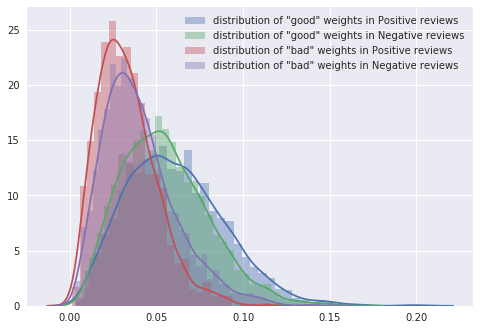

In [27]:
# https://seaborn.pydata.org/tutorial/distributions.html
import seaborn as sns
sns.set(color_codes=True)
sns.distplot(weights_to_plot[True]['good'], norm_hist=True, label='distribution of "good" weights in Positive reviews')
sns.distplot(weights_to_plot[False]['good'], norm_hist=True, label='distribution of "good" weights in Negative reviews')

sns.distplot(weights_to_plot[True]['bad'], norm_hist=True, label='distribution of "bad" weights in Positive reviews')
sns.distplot(weights_to_plot[False]['bad'], norm_hist=True, label='distribution of "bad" weights in Negative reviews')
plt.legend()
plt.show()